# **Optimization for Data Science Exam Project**
Filippo Dalla Zuanna, mat.1238613

In [ ]:
!nvidia-smi

Mon Aug 24 14:23:48 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preliminar phases

In [ ]:
#MAIN FOLDER PATH
import os
PATH = '/content/drive/My Drive/Colab Notebooks/Optimization for Data Science'
os.chdir(PATH)
print('The work is in path:', os.getcwd())

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sys
import glob
from DenseNet3 import *
from WideResNet import *
#from dfw import *
#from bpgrad import *

The work is in path: /content/drive/My Drive/Colab Notebooks/Optimization for Data Science


## Device Selection and Performance

In [ ]:
cpu_default = False

global device
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(dev)
device_cpu = torch.device("cpu")

if cpu_default: device=device_cpu

#parameters to normalize time performance to Tesla P4, CUDA Benchmarks at geekbench.com
if torch.cuda.is_available():
  Tesla_T4_bench = 81420
  Tesla_P100_bench = 82476  
  Tesla_P4_bench = 48550
  Tesla_K80_bench = 15653

  if torch.cuda.get_device_name(0) == 'Tesla T4':
    bench_factor = Tesla_T4_bench/Tesla_T4_bench
    print('Device:', torch.cuda.get_device_name(0),
          ', as fast as {} Tesla T4 GPUs'.format(round(bench_factor,2)))

  elif torch.cuda.get_device_name(0) == 'Tesla P100-PCIE-16GB':
    bench_factor = Tesla_P100_bench/Tesla_T4_bench
    print('Device:', torch.cuda.get_device_name(0),
          ', as fast as {} Tesla T4 GPUs'.format(round(bench_factor,2)))
    
  elif torch.cuda.get_device_name(0) == 'Tesla P4':
    bench_factor = Tesla_P4_bench/Tesla_T4_bench
    print('Device:', torch.cuda.get_device_name(0),
          ', as fast as {} Tesla T4 GPUs'.format(round(bench_factor,2)))
  
  elif torch.cuda.get_device_name(0) == 'Tesla K80':
    bench_factor = Tesla_K80_bench/Tesla_T4_bench
    print('Device:', torch.cuda.get_device_name(0),
          ', as fast as {} Tesla T4 GPUs'.format(round(bench_factor,2)))


Device: Tesla P100-PCIE-16GB , as fast as 1.01 Tesla T4 GPUs


## Load Dataset

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

traindata = torchvision.datasets.CIFAR10(root=os.getcwd(), train=True, 
                                         download=True, transform=transform)
train_fraction=1       #fraction of training set, total 60000 elements
val_fraction=1/10      #fraction of validation set over the training set chosen
train_idx = range(int(len(traindata)*train_fraction - len(traindata)*train_fraction*val_fraction))
val_idx = range(int(len(traindata)*train_fraction - len(traindata)*train_fraction*val_fraction), int(len(traindata)*train_fraction))
train_subs = torch.utils.data.Subset(traindata, train_idx)
val_subs = torch.utils.data.Subset(traindata, val_idx)
trainloader = torch.utils.data.DataLoader(train_subs, batch_size=128,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_subs, batch_size=128,
                                          shuffle=True, num_workers=2)

testdata = torchvision.datasets.CIFAR10(root=PATH, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testdata, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
          'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print()
print("Number of training elements: ",len(train_idx))
print("Number of validation elements: ",len(val_idx))
print("Number of test elements: ",len(testdata))

Files already downloaded and verified
Files already downloaded and verified

Number of training elements:  45000
Number of validation elements:  5000
Number of test elements:  10000


## Loss and Optimizer classes

### Multi class Hinge loss

In [ ]:
import torch
import torch.nn as nn

class MultiClassHingeLoss(nn.Module):
    r"""Implements the Multi-Class Hinge Loss proposed in the provided paper.
     
    """

    smooth = False

    def __init__(self):
        super(MultiClassHingeLoss, self).__init__()
        self.smooth = False
        self._range = None

    def forward(self, x, y):
        if self._range is None:
            delattr(self, '_range')
            # creates a Tensor [0,1,2,...n-1] where n is the num of classes (10 in this case)
            self.register_buffer('_range', torch.arange(x.size(1), device=x.device)[None, :])

        # elem is = 0 if the label y coincides with the one of _range, 1 otherwise
        delta = torch.ne(y[:, None], self._range).detach().float()
        augm_scores = x + delta - x.gather(1, y[:, None])
        #print(x.gather(1, y[:, None]))
        
        # compute the max of the augmented scores (only interested in the labels)
        _, y_max = torch.max(augm_scores, 1)
        # get the indeces vector of the max labels
        ind_max = torch.eq(y_max[:, None], self._range).float()

        # apply smoothing, if possible (Appendix A.6 of the paper)
        if MultiClassHingeLoss.smooth:
            # compute softmax of the scores            
            ind_smooth = nn.functional.softmax(x, dim=1)
            # computes s^T*v and check if > 0
            losses = torch.sum(augm_scores * ind_smooth, 1)
            # mask_smooth has value 1 for ascend indices and 0 for descend indices
            mask_smooth = torch.ge(losses, 0).float()[:, None]
            # apply mask, that is taking the cross-entropy gradient for the ascend 
            # directions and hinge subgradient otherwise 
            ind = mask_smooth * ind_smooth + (1 - mask_smooth) * ind_max
        else:
            ind = ind_max
        
        loss = torch.sum(augm_scores * ind) / x.size(0)
        #print(loss)
        #print(ind)
        return loss

    def __repr__(self):
        return 'MultiClassHingeLoss()'

class smoothing_enabler(object):
    def __init__(self, mode):
        MultiClassHingeLoss.smooth = bool(mode)
    
    def __enter__(self):
        pass

    def __exit__(self, exc_type, exc_val, exc_tb):
        MultiClassHingeLoss.smooth = False


### Deep Frank Wolf optimizer

In [ ]:
import torch 
import torch.optim as optim

from torch.optim.optimizer import required
from collections import defaultdict

class DFW(optim.Optimizer):
    r"""

    Implements the Deep Franke Wolfe Optimizer: please notice that this optimizer 
    is built using the same structure of SGD Optimizer. Other parameters are 
    though required:

    - lr: not required, since its concept is embedded in the stepsize derivation

    - eta: proximal coefficient, the only parameter to be tuned (but 
      once fixed, it's constant)

    - eps: this is a utility constant, used to avoid zero-denominator 
      (instability) situations when computing the step size

    - mu: momentum coefficient

    - weight decay: is the penalty term of the L2 regularizer applied

    """
    def __init__(self, params, eta=required, momentum=0, 
                 weight_decay=0, eps=1e-5):
        if eta is not required and eta <= 0.0:
            raise ValueError("Invalid eta: {}".format(eta))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(eta=eta, momentum=momentum, weight_decay=weight_decay)
        super(DFW, self).__init__(params, defaults)
        self.eps = eps

        for group in self.param_groups:
            if group['momentum']:
                for p in group['params']:
                    self.state[p]['momentum_buffer'] = torch.zeros_like(p.data, requires_grad=False) #initialization of momentum velocity

    @torch.autograd.no_grad()
    def step(self, closure):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the (non-regularized) loss.
        """
        loss = float(closure())

        w_dict = defaultdict(dict)
        for group in self.param_groups:
            weight_decay = group['weight_decay']
            for p in group['params']:
                if p.grad is None:
                    continue
                w_dict[p]['delta_t'] = p.grad.data # derivative of the loss function (delta_t)
                w_dict[p]['r_t'] = weight_decay * p.data # derivative of the L2 regularizer
                                                                # here, SGD proceeds in another manner, but the result is the same

        self._line_search(loss, w_dict)

        for group in self.param_groups:
            eta = group['eta']
            mu = group['momentum']
            for p in group['params']:
                if p.grad is None:
                    continue
                state = self.state[p]
                delta_t, r_t = w_dict[p]['delta_t'], w_dict[p]['r_t']

                p.data -= eta * (r_t + self.gamma * delta_t)

                if mu:
                    z_t = state['momentum_buffer']
                    z_t = mu * z_t - eta * self.gamma * (r_t + delta_t)
                    p.data += mu * z_t

    @torch.autograd.no_grad()
    def _line_search(self, loss, w_dict):
        """
        Computes the linesearch in closed form
        """
        num = loss
        denom = 0

        for group in self.param_groups:
            eta = group['eta']
            for p in group['params']:
                if p.grad is None:
                    continue
                delta_t, r_t = w_dict[p]['delta_t'], w_dict[p]['r_t']
                num -= eta * torch.sum(delta_t * r_t) 
                denom += eta * delta_t.norm() ** 2
        
        self.gamma = float((num / (denom + self.eps)).clamp(min=0, max=1)) # computes the (stable) step-size, clipped to [0,1]
        

### AMSGrad optimizer

In [ ]:
import math
import torch
import torch.optim as optim
from torch.optim.optimizer import required

class AMSGrad(optim.Optimizer):
    def __init__(self, params, eta=required, b1=0.9, b2=0.999, weight_decay=0, eps=1e-8):
        if eta is not required and eta <= 0.0:
            raise ValueError("Invalid eta: {}".format(eta))
        if b1 < 0.0 or b1 > 1.0:
            raise ValueError("Invalid beta1 value: {}".format(b1))
        if b2 < 0.0 or b2 > 1.0:
            raise ValueError("Invalid beta2 value: {}".format(b2))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        
        defaults = dict(eta=eta, b1=b1, b2=b2, weight_decay=weight_decay, eps=eps)
        super(AMSGrad, self).__init__(params, defaults)
        self.eps = eps

        for group in self.param_groups:
            for p in group['params']:
                self.state[p]['step'] = 0
                self.state[p]['b1'] = b1
                self.state[p]['b2'] = b2
                self.state[p]['m'] = torch.zeros_like(p)
                self.state[p]['v'] = torch.zeros_like(p)
                self.state[p]['v_max'] = torch.zeros_like(p, requires_grad=False)

    @torch.autograd.no_grad()
    def step(self, closure):
        loss = closure()
        for group in self.param_groups:
            for p in group['params']:
                m, v, v_max = self.state[p]['m'], self.state[p]['v'], self.state[p]['v_max']
                b1, b2 = self.state[p]['b1'], self.state[p]['b2']
                self.state[p]['step'] += 1
                bias_correction1 = 1 - b1 ** self.state[p]['step']
                bias_correction2 = 1 - b2 ** self.state[p]['step']
                
                if group['weight_decay']:
                    # calculate gradient of the regularized function
                    p.grad = p.grad.add(p, alpha=group['weight_decay'])
                m.mul_(b1).add_(p.grad, alpha= 1-b1)
                v.mul_(b2).addcmul_(p.grad, p.grad, value = 1-b2)
                v_max = torch.max(v_max, v)
                den = v_max.sqrt() / (math.sqrt(bias_correction2) + group['eps'])
                step_size = group['eta'] / bias_correction1
                p.addcdiv_(m, den, value=-step_size)

                self.gamma = step_size

        return loss

### Branching and Pruning optimizer 

In [ ]:
import torch
import torch.optim as optim

from torch.optim.optimizer import required

class BPGrad(optim.Optimizer):
    r"""

        Implements the BPGrad Optimizer: please notice that this optimizer 
        is built using the same structure of SGD Optimizer. This optimizer is built 
        on Algorithm 2 of https://arxiv.org/abs/1711.06959.
        The authors suggest to simplify the notation (because of empirical results 
        discussed in the paper) by setting N = 1, that leads to m = 1 and rho = 0.
        Other parameters are though required:

        - eta: learning rate

        - eps: this is a utility constant, used to avoid zero-denominator 
            (instability) situations when computing the step size

        - mu: momentum coefficient

        - weight decay: is the penalty term of the L2 regularizer applied

    """

    def __init__(self, params, eta=required, momentum=0, weight_decay=0, eps=1e-5):
        if eta is not required and eta <= 0.0:
            raise ValueError("Invalid eta: {}".format(eta))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        
        defaults = dict(eta=eta, momentum=momentum, weight_decay=weight_decay)
        super(BPGrad, self).__init__(params, defaults)
        self.eps = eps

        for group in self.param_groups:
            group['L'] = 1./group['eta'] # why? try diff vals
            if group['momentum']:
                for p in group['params']:
                    self.state[p]['v'] = torch.zeros_like(p.data, requires_grad=False)

    @torch.autograd.no_grad()
    def step(self, closure):
        num = float(closure())
        for group in self.param_groups:
            weight_decay = group['weight_decay']
            for p in group['params']:
                num += 0.5 * weight_decay * p.data.norm() ** 2 # regularized fcn
                p.grad.data += weight_decay * p.data # gradient of the regularized fcn

        grad_norm = 0 # norm of the gradient
        for group in self.param_groups:
            for p in group['params']:
                grad_norm += p.grad.data.norm() ** 2

        step_size = float((num / (torch.sqrt(grad_norm) + self.eps)))

        for group in self.param_groups:
            L = group['L']
            mu = group['momentum']
            for p in group['params']:
                v = self.state[p]['v']
                if mu:
                    v *= mu
                v -= step_size / L * p.grad.data
                p.data += v

        self.gamma = step_size

# Model Training

## Parameters

In [ ]:
import os
import timeit

train_minutes = 0 # max training time
train_epochs = 200 # max epochs
epochs_save = 10

net = 'densenet'   # NETS: 'widenet' : WideResNet, 'densenet': DenseNet
opt = 'dfw'       # OPTIM: 'sgd', 'dfw', 'bpgrad', 'amsgrad'

eta_vec = [1e-1,1e-2,1e-3]

path_net = os.getcwd() + '/nets/'
if not os.path.exists(path_net):
    os.mkdir(path_net)

path_net+= 'net_{}_opt_{}_eta_{}/'
for eta in eta_vec:
  if not os.path.exists(path_net.format(net,opt,eta)):
    os.mkdir(path_net.format(net,opt,eta))

checkpointName = "checkpoint_net_{}_opt_{}_loss_{}_eta_{}_epoch_{}.tar"

## Training

In [ ]:
for eta in eta_vec:
        if net is 'widenet':
            netw = WideResNet(depth=40, num_classes=10, widen_factor=4).to(device)
        elif net is 'densenet':
            netw = DenseNet3(depth=40, num_classes=10, growth_rate=40).to(device)

        if opt is 'dfw':
            optim = DFW(netw.parameters(), eta=eta, momentum=0.9, weight_decay=1e-4)
            loss_fn = MultiClassHingeLoss()
        elif opt is 'sgd':
            optim = torch.optim.SGD(netw.parameters(), lr=eta, momentum=0.9)
            loss_fn = nn.CrossEntropyLoss()
        elif opt is 'bpgrad':
            optim = BPGrad(netw.parameters(), eta=eta, momentum=0.9, weight_decay=1e-4)
            loss_fn = nn.CrossEntropyLoss()
        elif opt is 'amsgrad':
            optim = AMSGrad(netw.parameters(), eta=eta, weight_decay=1e-4, eps=1e-8)
            loss_fn = nn.CrossEntropyLoss()
        
        train_loss_log = []        
        val_loss_log = []
        train_acc_log = []
        val_acc_log = []
        lr_log = []
        time_log = []
        minutes_done = 0
        epoch = 1
                
        for i in os.listdir(path=path_net.format(net,opt,eta)):
            check_loaded = torch.load(path_net.format(net,opt,eta) + i, map_location=device)
            netw.load_state_dict(check_loaded['net_state_dict'])
            optim.load_state_dict(check_loaded['optim_state_dict'])            
            train_loss_log = check_loaded['train_loss_log']            
            val_loss_log = check_loaded['val_loss_log']
            train_acc_log = check_loaded['train_acc_log']
            val_acc_log = check_loaded['val_acc_log']
            lr_log = check_loaded['lr_log']
            time_log = check_loaded['time_log']
            minutes_done = time_log[-1]
            epoch = len(time_log) +1
            if minutes_done > train_minutes  : break

        print('----------------------------START TRAINING---------------------------')
        print('Model:{}, Optim:{}, Learning Rate:{}, Start Epoch:{}, Start Minute:{}'
            .format(net,opt,eta,epoch,round(minutes_done,1)))
        print('---------------------------------------------------------------------\n')
        while(minutes_done<train_minutes and epoch<=train_epochs):
            train_loss_vec = []
            val_loss_vec = [] 

            if (opt is 'sgd'):
              if len(lr_log)!=0: eta_temp = lr_log[-1]                
              if ((epoch)%60 == 0 or (epoch)%120 == 0 or (epoch)%180 == 0):
                print("Decrease learning rate at epoch ",epoch)
                eta_temp = lr_log[-1]/5
                for g in optim.param_groups:
                  g['lr'] = g['lr']/5          
            
            #Train
            time_start=timeit.default_timer()
            netw.train()
            for i, data in enumerate(trainloader, 0):
                input, labels = data
                
                labels_pred = netw(input.to(device))
                if opt is 'dfw':
                    with smoothing_enabler(True):
                        loss = loss_fn(labels_pred, labels.to(device))
                else:
                    loss = loss_fn(labels_pred, labels.to(device))

                optim.zero_grad()
                loss.backward()
                optim.step(lambda: float(loss))
                train_loss_vec.append(loss.item())           
            
            #Validation
            netw.eval()
            with torch.no_grad():
                for i, data in enumerate(valloader, 0):
                    input, labels = data
                    labels_pred = netw(input.to(device))
                    if opt is 'dfw':
                        with smoothing_enabler(True):
                            loss = loss_fn(labels_pred, labels.to(device))
                    else:
                        loss = loss_fn(labels_pred, labels.to(device))
                    val_loss_vec.append(loss.item())            
            
            minutes_done += (timeit.default_timer()-time_start)/60 * bench_factor

            # Logs
            train_loss_log.append(np.mean(train_loss_vec))
            val_loss_log.append(np.mean(val_loss_vec))

            correct = 0
            total = 0
            with torch.no_grad():
                for data in trainloader:
                    images, labels = data
                    output = netw(images.to(device))
                    _, predictions = torch.max(output.data, 1)
                    total += labels.size(0)
                    correct += (predictions.to(device) == labels.to(device)).sum().item()
            train_acc_log.append(100*correct/total)

            correct = 0
            total = 0
            with torch.no_grad():
                for data in valloader:
                    images, labels = data
                    output = netw(images.to(device))
                    _, predictions = torch.max(output.data, 1)
                    total += labels.size(0)
                    correct += (predictions.to(device) == labels.to(device)).sum().item()
            val_acc_log.append(100*correct/total)

            if opt is 'dfw':
                lr_log.append(optim.gamma * eta)
            elif opt is 'sgd':
                if len(lr_log)!=0: lr_log.append(eta_temp)
                else: lr_log.append(eta)
            elif opt is 'bpgrad':
                lr_log.append(optim.gamma)
            elif opt is 'amsgrad':
                lr_log.append(optim.gamma)
                
                

            time_log.append(minutes_done)
            print('Epoch %d, Minute %.1f:\n\t Train Loss, Accuracy: %.3f,%.1f %% \n\t Validation Loss, Accuracy: %.3f,%.1f %%' 
                  %(epoch, minutes_done, train_loss_log[-1], train_acc_log[-1], val_loss_log[-1], val_acc_log[-1]))
            
            #Checkpoint          
            if (epoch)%epochs_save==0 or minutes_done>=train_minutes:
                print("Saving checkpoint: Epoch {}".format(epoch))
                checkpoint = {  "net_state_dict"    : netw.state_dict(),
                                "optim_state_dict"  : optim.state_dict(),
                                "train_loss_log"    : train_loss_log,
                                "val_loss_log"      : val_loss_log,
                                "train_acc_log"     : train_acc_log,
                                "val_acc_log"       : val_acc_log,
                                "lr_log"            : lr_log,                              
                                "time_log"          : time_log}
                path_save = path_net.format(net,opt,eta) + checkpointName                                                
                torch.save(checkpoint, path_save.format(net, opt, loss_fn, eta, epoch))
            
            #Increase for next epoch
            epoch += 1
    
        

----------------------------START TRAINING---------------------------
Model:densenet, Optim:dfw, Learning Rate:0.1, Start Epoch:11, Start Minute:28.5
---------------------------------------------------------------------

----------------------------START TRAINING---------------------------
Model:densenet, Optim:dfw, Learning Rate:0.01, Start Epoch:11, Start Minute:28.7
---------------------------------------------------------------------

----------------------------START TRAINING---------------------------
Model:densenet, Optim:dfw, Learning Rate:0.001, Start Epoch:11, Start Minute:28.2
---------------------------------------------------------------------



# Model Evaluation

## Parameters

In [ ]:
net = 'densenet'
opt_list = ['amsgrad','bpgrad','dfw','sgd']
eta_list = [1e-1,1e-2,1e-3]
max_training_time = 250

path_folder = os.getcwd() + '/nets/'
if not os.path.exists(path_folder):
    raise Exception('Wrong folder selected')


## Evaluation

-----------------------------------------------------------------------------------




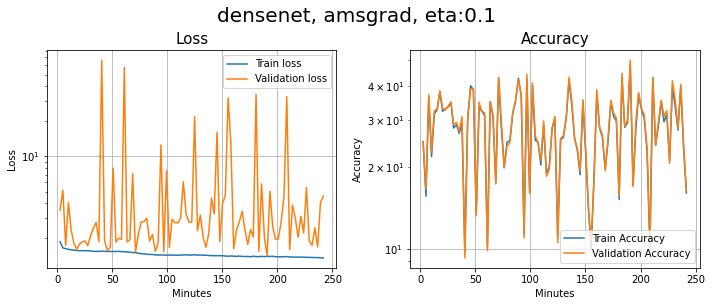

Validation Maximum:  193.18  minutes,  49.76 % accuracy
Accuracy of the network on the 10000 test images: 37 %
-----------------------------------------------------------------------------------




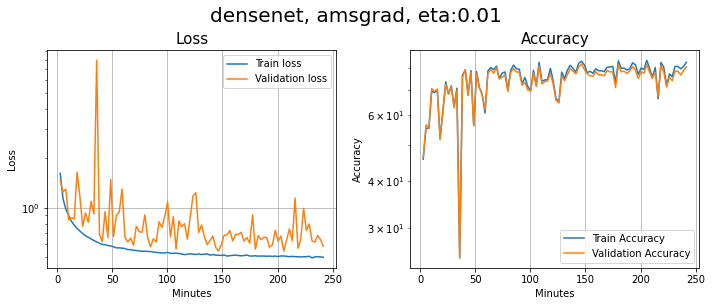

Validation Maximum:  148.99  minutes,  81.94 % accuracy
Accuracy of the network on the 10000 test images: 64 %
-----------------------------------------------------------------------------------




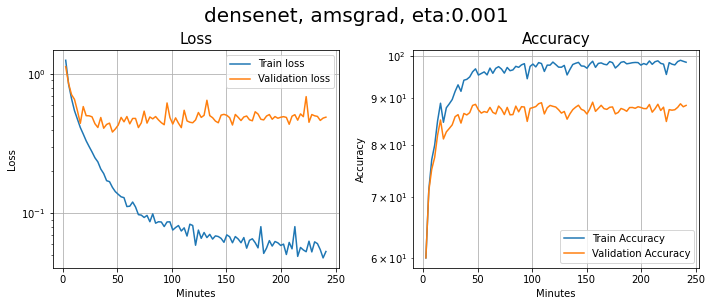

Validation Maximum:  158.14  minutes,  89.06 % accuracy
Accuracy of the network on the 10000 test images: 75 %
-----------------------------------------------------------------------------------




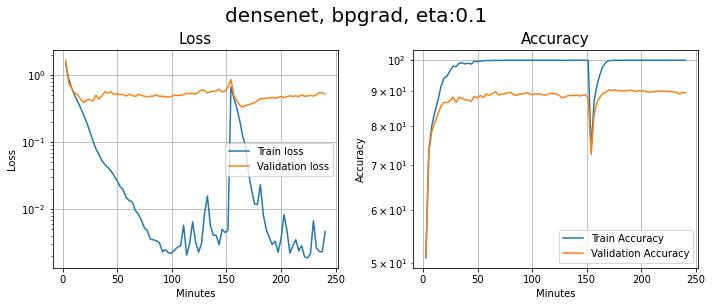

Validation Maximum:  172.97  minutes,  90.42 % accuracy
Accuracy of the network on the 10000 test images: 73 %
-----------------------------------------------------------------------------------




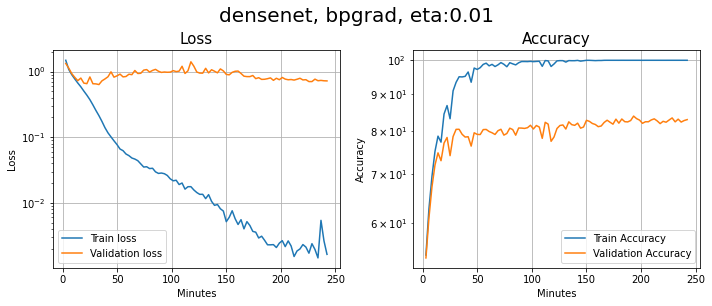

Validation Maximum:  195.9  minutes,  83.94 % accuracy
Accuracy of the network on the 10000 test images: 64 %
-----------------------------------------------------------------------------------




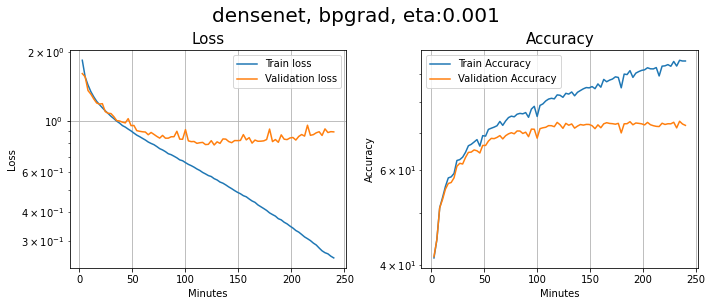

Validation Maximum:  237.33  minutes,  73.7 % accuracy
Accuracy of the network on the 10000 test images: 52 %
-----------------------------------------------------------------------------------




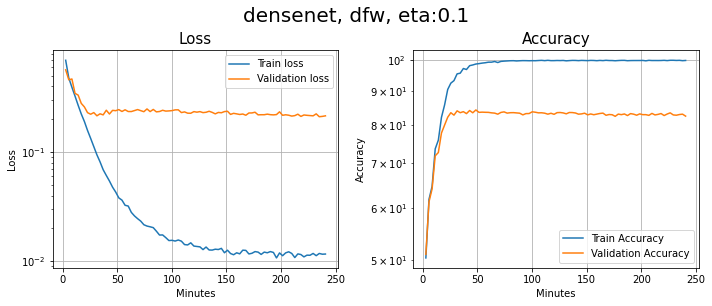

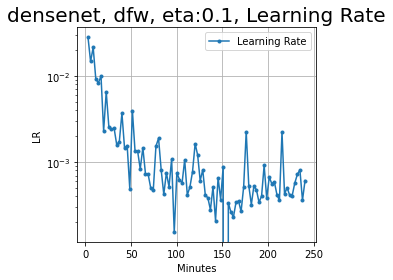

Validation Maximum:  51.43  minutes,  84.18 % accuracy
Accuracy of the network on the 10000 test images: 67 %
-----------------------------------------------------------------------------------




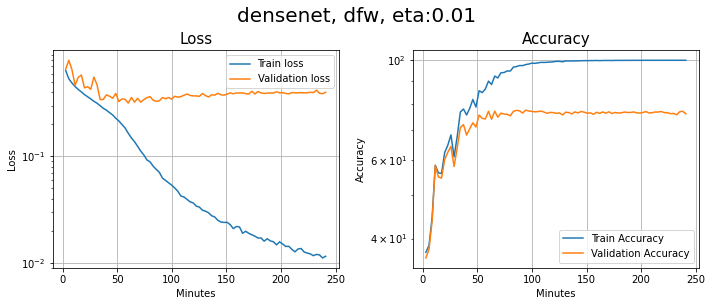

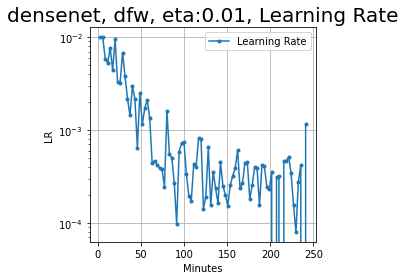

Validation Maximum:  97.08  minutes,  77.4 % accuracy
Accuracy of the network on the 10000 test images: 61 %
-----------------------------------------------------------------------------------




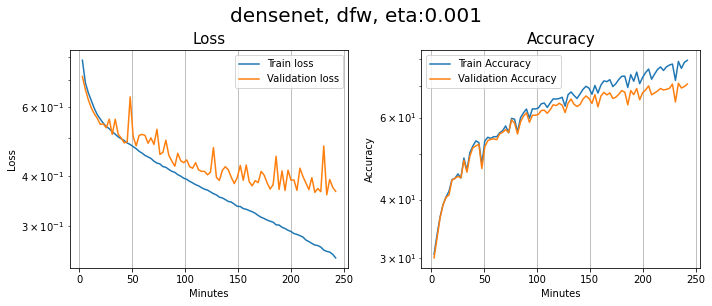

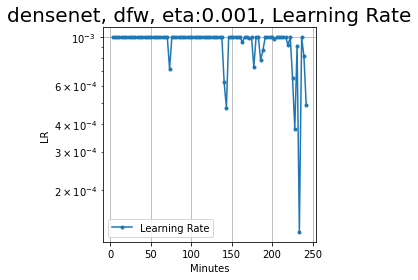

Validation Maximum:  236.46  minutes,  71.1 % accuracy
Accuracy of the network on the 10000 test images: 54 %
-----------------------------------------------------------------------------------




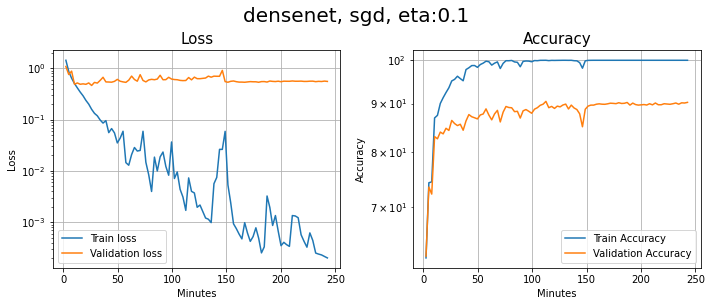

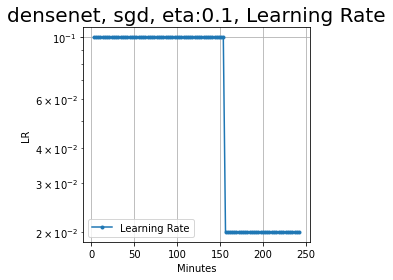

Validation Maximum:  115.3  minutes,  90.48 % accuracy
Accuracy of the network on the 10000 test images: 77 %
-----------------------------------------------------------------------------------




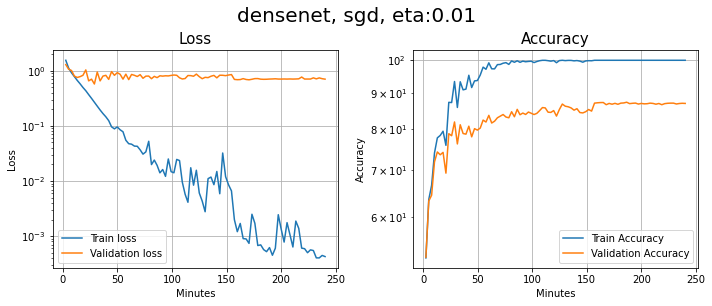

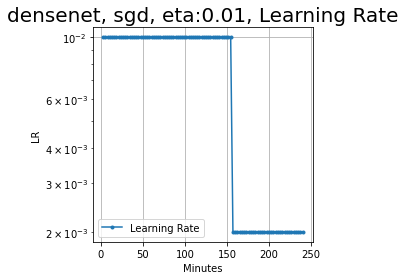

Validation Maximum:  189.31  minutes,  87.26 % accuracy
Accuracy of the network on the 10000 test images: 72 %
-----------------------------------------------------------------------------------




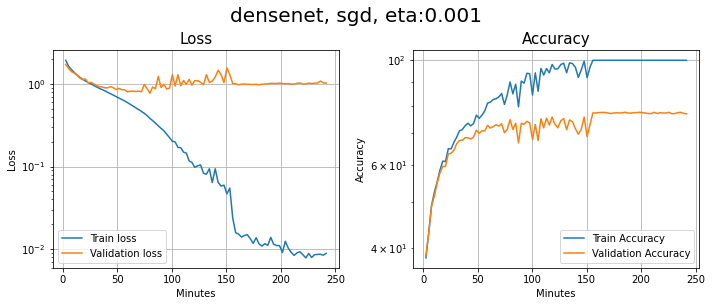

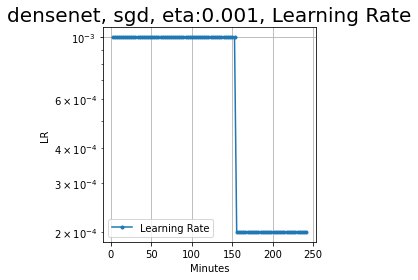

Validation Maximum:  187.93  minutes,  77.58 % accuracy
Accuracy of the network on the 10000 test images: 59 %


In [ ]:
for opt in opt_list:
  for eta in eta_list:

    print("-----------------------------------------------------------------------------------\n\n")
    path_net = path_folder + 'net_{}_opt_{}_eta_{}/'
    if not os.path.exists(path_net.format(net,opt,eta)):
        print('Wrong model selected, switch to next')
        break

    if net is 'widenet':
        netw = WideResNet(depth=40, num_classes=10, widen_factor=4).to(device)
    elif net is 'densenet':
        netw = DenseNet3(depth=40, num_classes=10, growth_rate=40).to(device)

    for i in os.listdir(path=path_net.format(net,opt,eta)):
        check_loaded = torch.load(path_net.format(net,opt,eta) + i, map_location=device)
        netw.load_state_dict(check_loaded['net_state_dict'])
        #optim.load_state_dict(check_loaded['optim_state_dict'])            
        train_loss_log = check_loaded['train_loss_log']            
        val_loss_log = check_loaded['val_loss_log']
        train_acc_log = check_loaded['train_acc_log']
        val_acc_log = check_loaded['val_acc_log']
        lr_log = check_loaded['lr_log']
        time_log = check_loaded['time_log']
        minutes_done = time_log[-1]
        epoch = len(time_log) +1
        if minutes_done > max_training_time  : break

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
    fig.suptitle('{}, {}, eta:{}'.format(net,opt,eta), fontsize=20, y=1.05)
    # Plot losses
    ax1.set_title('Loss',fontsize=15)
    ax1.semilogy(time_log,train_loss_log, label='Train loss')
    ax1.semilogy(time_log,val_loss_log, label='Validation loss')
    ax1.set_xlabel('Minutes')
    ax1.set_ylabel('Loss')
    ax1.grid()
    ax1.legend() 

    # Plot accuracy
    ax2.set_title('Accuracy'.format(net,opt,eta),fontsize=15)
    ax2.semilogy(time_log,train_acc_log, label='Train Accuracy')
    ax2.semilogy(time_log,val_acc_log, label='Validation Accuracy')
    ax2.set_xlabel('Minutes')
    ax2.set_ylabel('Accuracy')
    ax2.grid()
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

    # Plot LR
    if opt=="sgd" or opt=="dfw":
      plt.figure(figsize=(5,4))
      plt.title('{}, {}, eta:{}, Learning Rate'.format(net,opt,eta),fontsize=20)
      plt.semilogy(time_log,lr_log, label='Learning Rate', marker='.')
      plt.xlabel('Minutes')
      plt.ylabel('LR')
      plt.grid()
      plt.legend()
      plt.tight_layout()
      plt.show()

    #Find maximum validation accuracy
    maximum = (1+np.argmax(val_acc_log), max(val_acc_log))
    print('Validation Maximum: ',round(time_log[maximum[0]],2)," minutes, ",maximum[1],"% accuracy")
    
    #Load Best Model
    best_model_selection=True
    if best_model_selection:
      training_epochs = round(maximum[0]/10) * 10
      for i in os.listdir(path=path_net.format(net,opt,eta)):
          check_loaded = torch.load(path_net.format(net,opt,eta) + i, map_location=device)
          netw.load_state_dict(check_loaded['net_state_dict'])
          #optim.load_state_dict(check_loaded['optim_state_dict'])            
          train_loss_log = check_loaded['train_loss_log']            
          val_loss_log = check_loaded['val_loss_log']
          train_acc_log = check_loaded['train_acc_log']
          val_acc_log = check_loaded['val_acc_log']
          lr_log = check_loaded['lr_log']
          time_log = check_loaded['time_log']
          minutes_done = time_log[-1]
          epoch = len(time_log) +1
          if epoch > training_epochs : break

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            output = netw(images.to(device))
            _, predictions = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predictions.to(device) == labels.to(device)).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
    